# Exploring Bulk Variables from the Spotter Archive

See [Spotter Technical Manual](https://content.sofarocean.com/hubfs/Spotter%20product%20documentation%20page/Sofar%20-%20Technical_Reference_Manual.pdf) for details on bulk wave parameters from directional wave buoys like Spotter.


This notebook demonstrates plotting from zarr stored on S3:
1. For a specific Spotter, map colored by time
2. For a specific Spotter, map colored by Hs
3. For a specific Spotter, time series of Hs
4. Deployment location and time of all Spotters
5. Location and Hs of all Spotters at a specific data.

All data access methods remain the same if using the netCDF file downloaded locally, e.g., `ds = xr.load_dataset(local_filename)`. The xarray + zarr allows for efficient remote access of the data without full download, but does require internet connection.

In [1]:
# Import necessary packages (you may need to pip install in your environment)

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs # for mapping
import xarray as xr
import datetime

import numpy as np

import s3fs
import matplotlib.dates as mdates

In [2]:
# open the file using xarray and zarr

s3_uri = "s3://sofar-spotter-archive/spotter_data/"

s3 = s3fs.S3FileSystem(anon=True)
store = s3fs.S3Map(root=s3_uri, s3=s3, check=False)
ds = xr.open_zarr(store=store, consolidated=True)


In [3]:
# chose a drifter by ID
spotter_id = 'SPOT-0164'


# create array that points to indices for each trajectory
traj_idx = np.insert(np.cumsum(ds.rowsize.values), 0, 0)


# find index of chosen drifter
j = np.where(ds.id==spotter_id)[0][0]
print(f"Drifter index for {spotter_id} is {j}")


# create the slice index `sli` for data from that drifter
sli = slice(traj_idx[j], traj_idx[j+1])


Drifter index for SPOT-0164 is 147


In [4]:
ds

<xarray.Dataset>
Dimensions:                (trajectory: 780, index: 6260688)
Coordinates:
    id                     (trajectory) object 'SPOT-010001' ... 'SPOT-1975'
  * index                  (index) int64 7839 8299 8761 ... 4359452 4359967
    time                   (index) datetime64[ns] ...
Dimensions without coordinates: trajectory
Data variables:
    latitude               (index) float64 ...
    level_0                (index) int64 ...
    longitude              (index) float64 ...
    meanDirection          (index) float64 ...
    meanDirectionalSpread  (index) float64 ...
    meanPeriod             (index) float64 ...
    peakDirection          (index) float64 ...
    peakDirectionalSpread  (index) float64 ...
    peakPeriod             (index) float64 ...
    rowsize                (trajectory) int64 2142 3276 3059 ... 4098 3404 3361
    significantWaveHeight  (index) float64 ...
Attributes:
    author:         Isabel A. Houghton
    creation_date:  2023-09-12 15:30:23.012812
    email:          isabel.houghton@sofarocean.com
    references:     https://content.sofarocean.com/hubfs/Spotter%20product%20...

## Plot drift trajectory colored by date

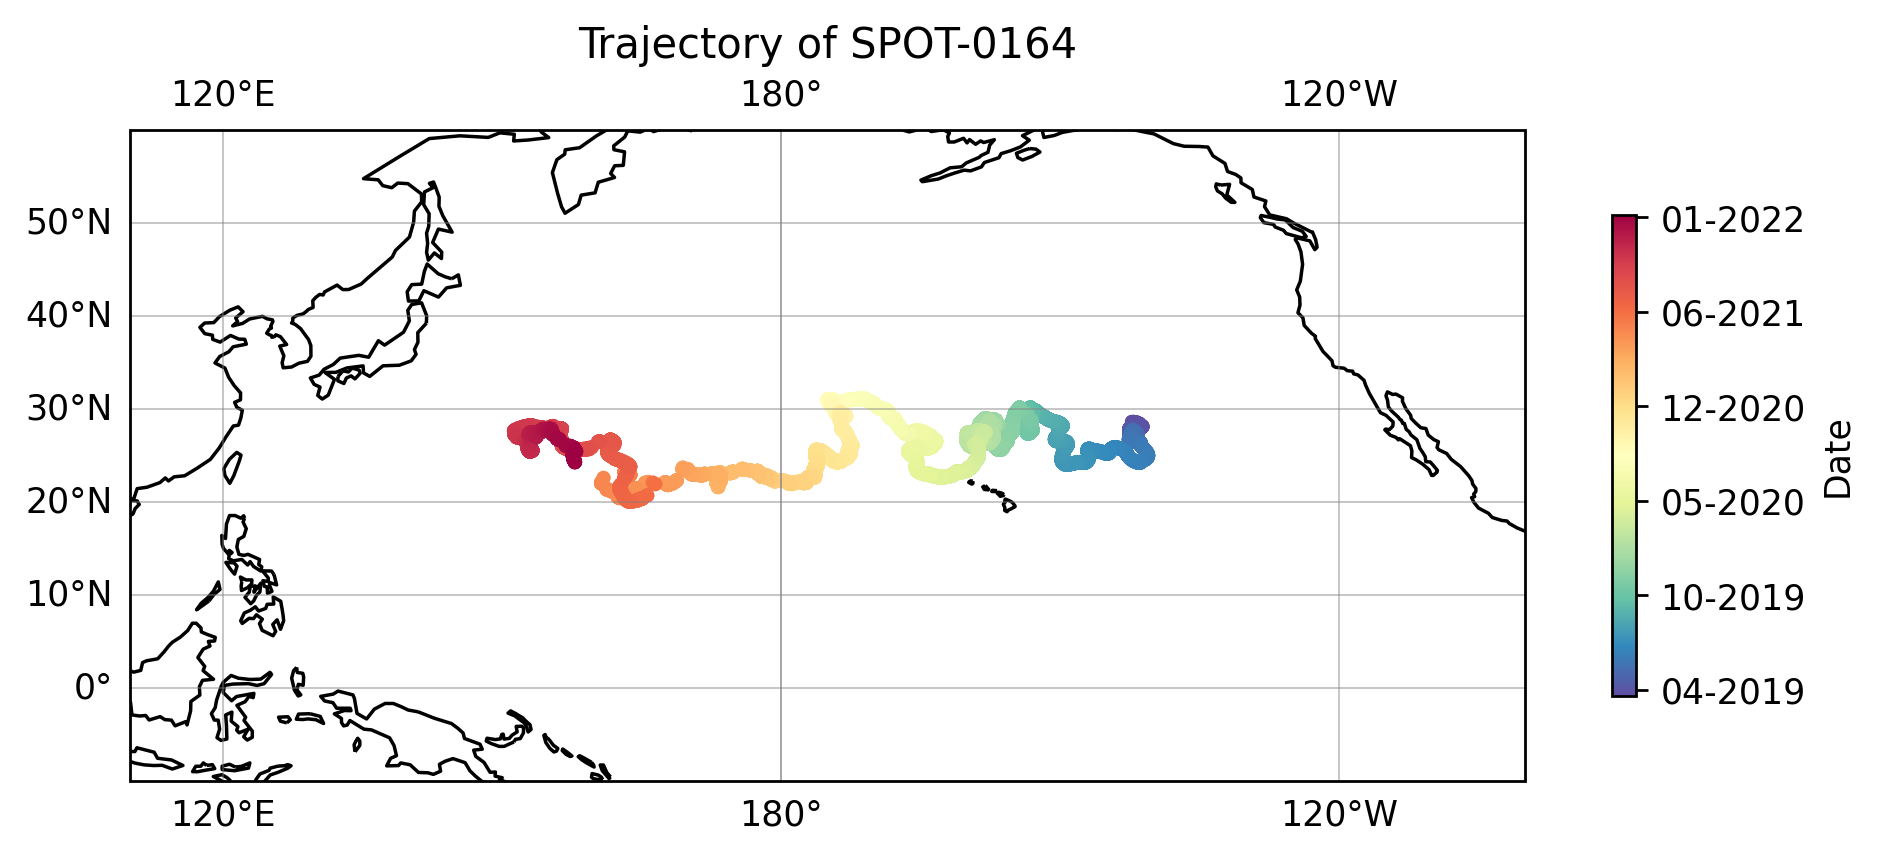

In [5]:
proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(1,1, figsize=[9,5], subplot_kw={'projection': proj}, dpi=250)

ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='gray', alpha=0.5)

ax.set_extent([110, 260, -10, 60], crs=ccrs.PlateCarree())

lons = ds.longitude[sli]
lons[lons<0] += 360 # Mercator project works [0, 360]
lats = ds.latitude[sli]
pcm1 = ax.scatter(lons, lats,
                  c=mdates.date2num(ds.time[sli]),
                  s=10,
                  cmap='Spectral_r',
                  edgecolor='face',
                  transform=ccrs.PlateCarree())

cb = fig.colorbar(pcm1,ax=ax, label='Date', shrink=0.5)
cb.ax.yaxis.set
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title('Trajectory of '+str(spotter_id))
plt.show()

## Plot drift trajectory colored by H$_s$

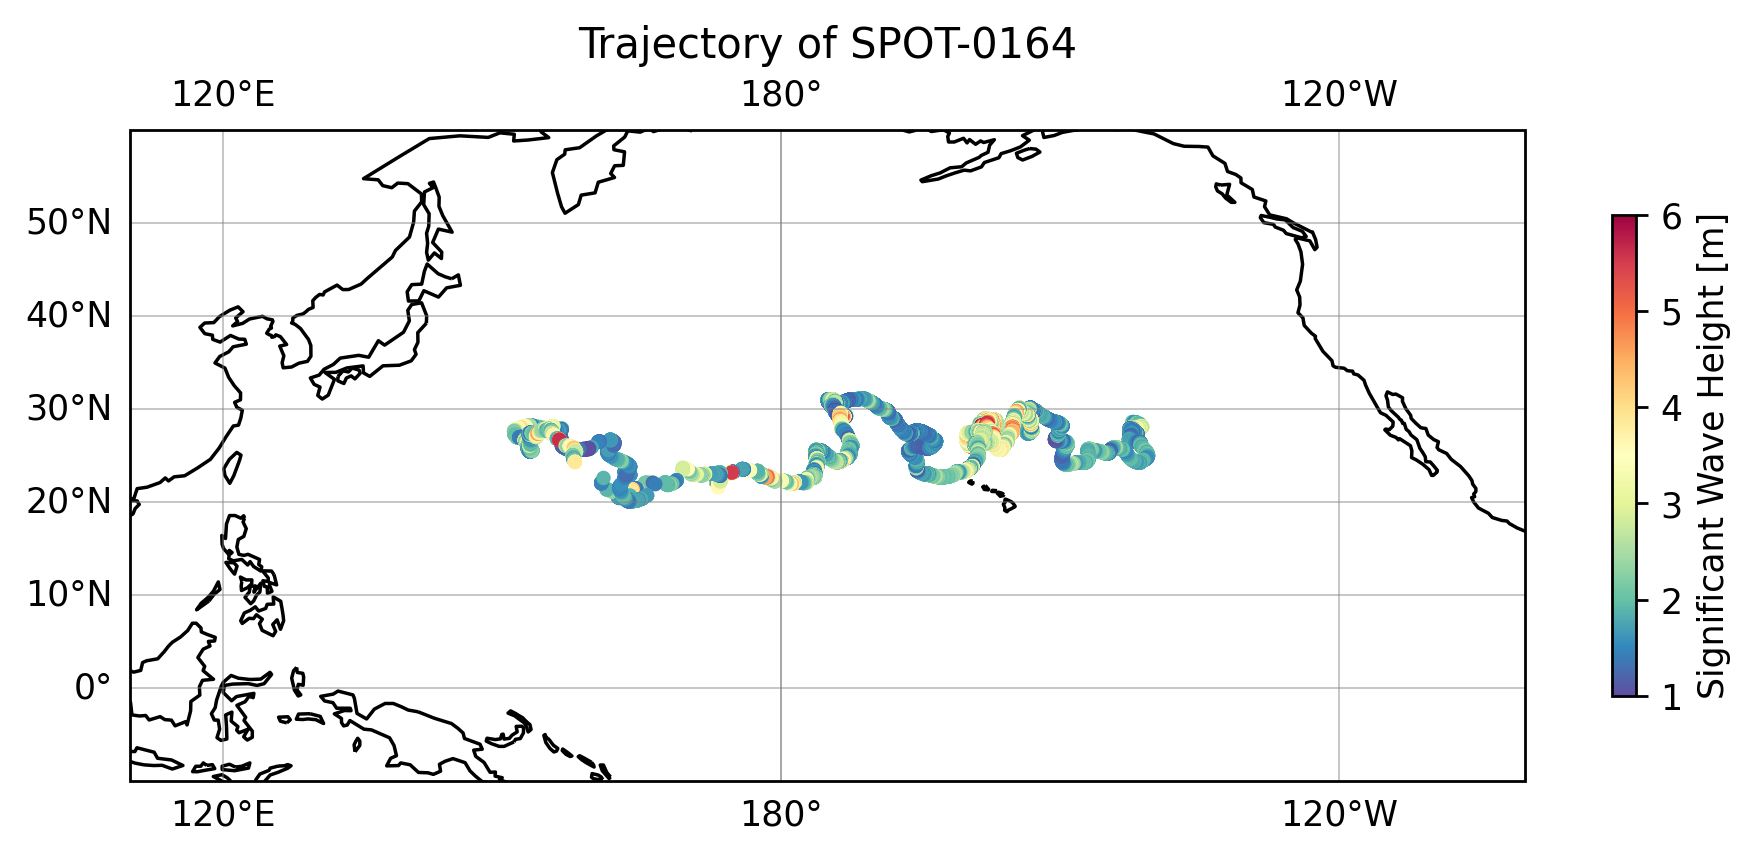

In [6]:
fig, ax = plt.subplots(1,1, figsize=[9,5], subplot_kw={'projection': proj}, dpi=250)

ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='gray', alpha=0.5)

ax.set_extent([110, 260, -10, 60], crs=ccrs.PlateCarree())


h_min = 1
h_max = 6

pcm1 = ax.scatter(lons, lats,
                  c=ds.significantWaveHeight[sli],
                  s=10,
                  cmap='Spectral_r',
                  edgecolor='face',
                  vmin=h_min, vmax=h_max,
                  transform=ccrs.PlateCarree())

cb = fig.colorbar(pcm1,ax=ax, label='Significant Wave Height [m]', shrink=0.5)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title('Trajectory of '+str(spotter_id))
plt.show()


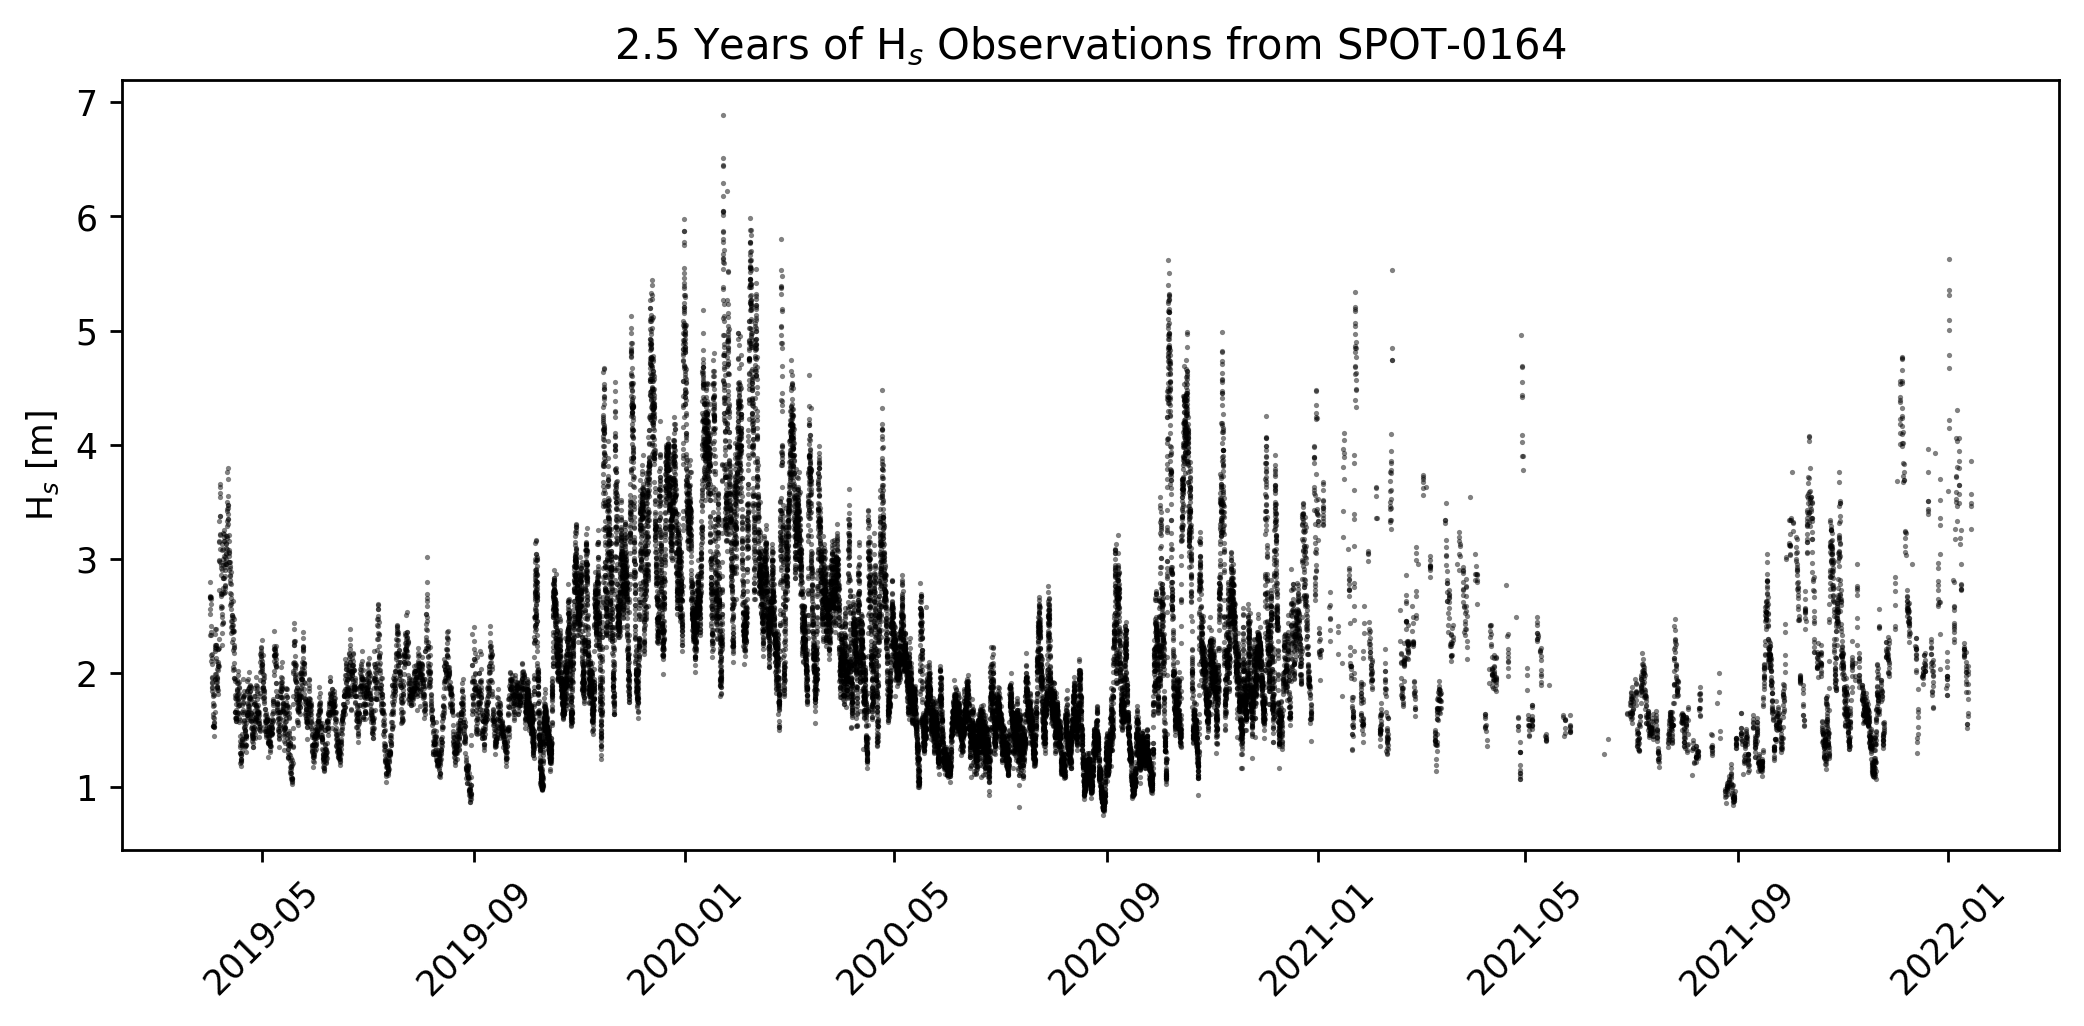

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10,4), dpi=250)
ax.scatter(ds.time[sli], ds.significantWaveHeight[sli], c='k',alpha=0.5, marker='.', s=1)
plt.xticks(rotation=45)
plt.ylabel('H$_s$ [m]')
plt.title(f"2.5 Years of H$_s$ Observations from {spotter_id}")
plt.show()

## Plot deployment location and time of all Spotters

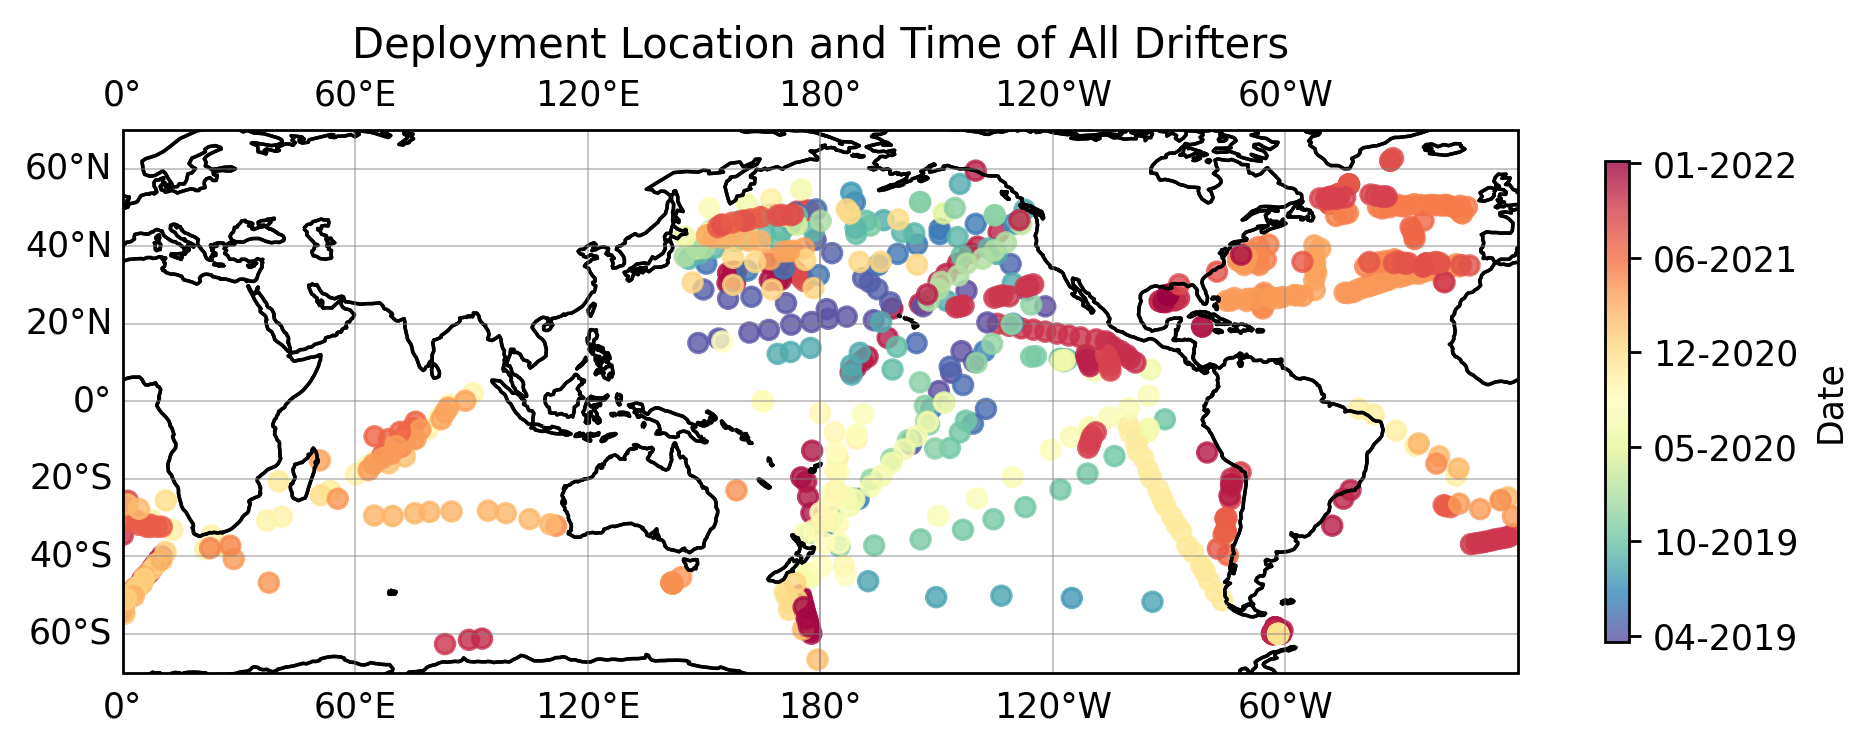

In [8]:
# loop over all trajectories and plot last location available (dataset ordered by time)

all_indices = []
# chose a drifter by ID
for spotter_id in ds.id.values:

    # find index of chosen drifter
    j = np.where(ds.id==spotter_id)[0][0]

    # create the index for data from that drifter
    all_indices.append(traj_idx[j]) # get the index of the first location



fig, ax = plt.subplots(1,1, figsize=[9,5], subplot_kw={'projection': proj}, dpi=250)

ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='gray', alpha=0.5)

ax.set_extent([0, 360, -70, 70], crs=ccrs.PlateCarree())
ax.coastlines()


pcm1 = ax.scatter(ds.longitude[all_indices], 
                  ds.latitude[all_indices],
                  c=mdates.date2num(ds.time[all_indices]),
                  s=30,
                  cmap='Spectral_r',
                  alpha=0.8,
                  transform=ccrs.PlateCarree())

cb = fig.colorbar(pcm1,ax=ax, label='Date', shrink=0.5)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title('Deployment Location and Time of All Drifters')
plt.show()

## All H$_s$ observations at a specific time

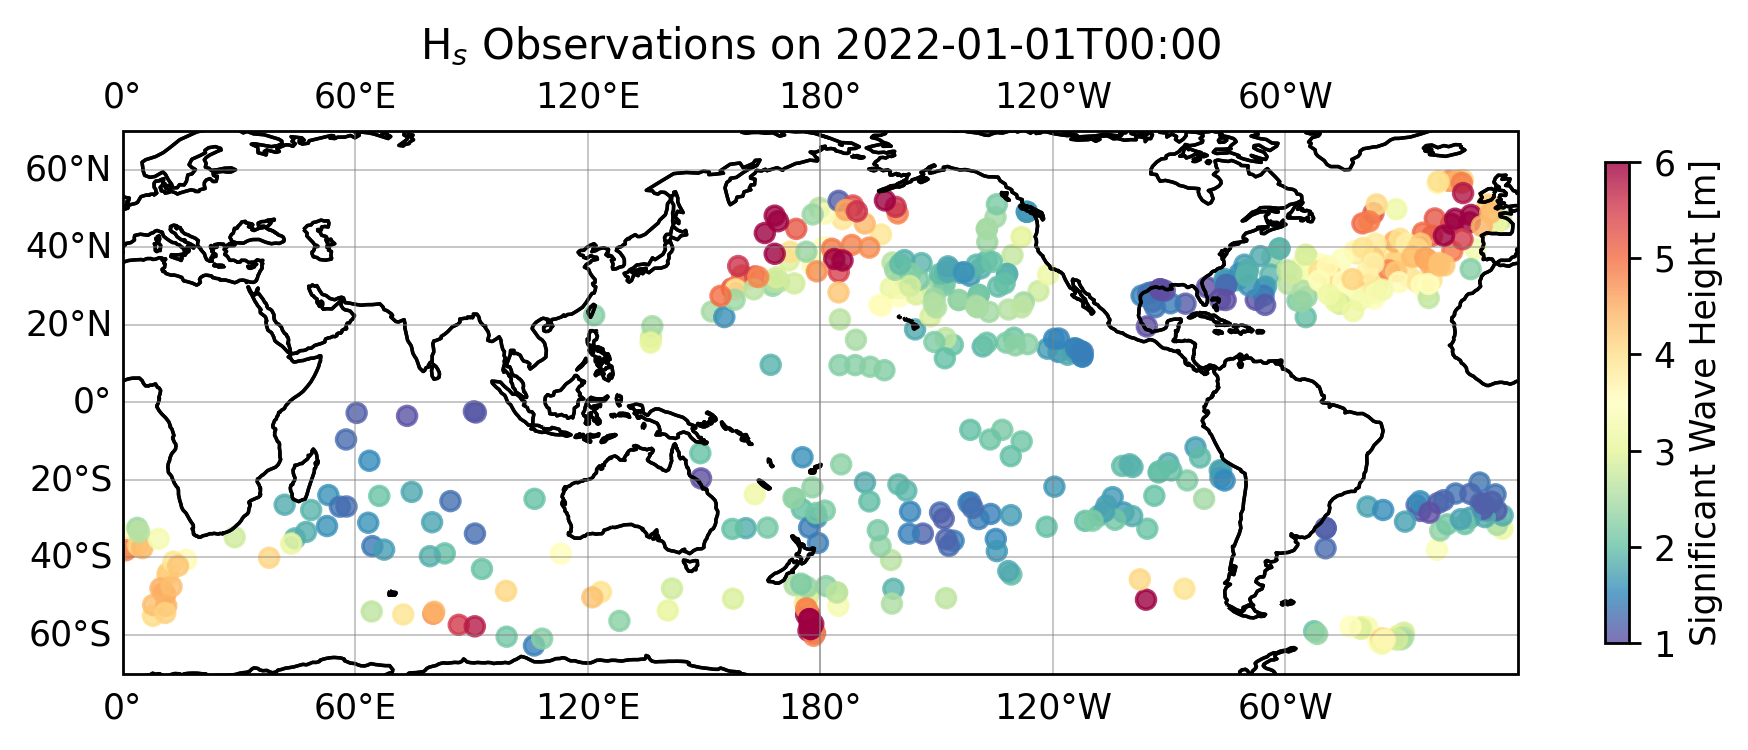

In [9]:
target_time_start = np.datetime64('2022-01-01T00:00')
target_time_end = np.datetime64('2022-01-01T01:00')

all_indices = np.where((ds.time>target_time_start) & (ds.time<target_time_end))[0]

fig, ax = plt.subplots(1,1, figsize=[9,5], subplot_kw={'projection': proj}, dpi=250)

ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='gray', alpha=0.5)

ax.set_extent([0, 360, -70, 70], crs=ccrs.PlateCarree())
ax.coastlines()


pcm1 = ax.scatter(ds.longitude[all_indices], 
                  ds.latitude[all_indices],
                  c=ds.significantWaveHeight[all_indices],
                  s=30,
                  cmap='Spectral_r',
                  alpha=0.8,
                  vmin=h_min, vmax=h_max,
                 transform=ccrs.PlateCarree())

cb = fig.colorbar(pcm1,ax=ax, label='Significant Wave Height [m]', shrink=0.5)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title(f'H$_s$ Observations on {target_time_start}')
plt.show()